In [14]:
import sys
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [15]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [16]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


In [17]:
# Analytical solutions needed for comparison
import analytical

In [18]:
def get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate, 
              advscheme='tvd', nstp=240,
              ctimes=None, cidx=None, verbosity_level=0):
    nlay, ncol = 1, 1
    nper = 1
    perlen = [120]
    nstp = [nstp]
    tsmult = [1.]
    steady = [True]
    delr = 1
    top = 1.
    botm = [0.]
    strt = 1.
    hnoflo = 1e30
    hdry = -1e30
    hk = 0.01
    laytyp = 0
    #ss = 0.
    #sy = 0.1

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-8, 1e-6, 1.

    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 verbosity_level=verbosity_level,
                                 exe_name=mf6exe,
                                 sim_ws=ws)
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname,
                            model_nam_file='{}.nam'.format(gwfname))

    # create iterative model solution and register the gwf model with it
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='CG',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname))
    sim.register_ims_package(imsgwf, [gwf.name])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=np.int),
                                  filename='{}.dis'.format(gwfname))

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=strt,
                                filename='{}.ic'.format(gwfname))

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_flows=False,
                                  save_specific_discharge=True,
                                  icelltype=laytyp,
                                  k=hk,
                                  k33=hk)

    # chd files
    c = {0: [[(0, nrow - 1, 0), 0.0000000]]}
    chd = flopy.mf6.ModflowGwfchd(gwf,
                                  stress_period_data=c,
                                  save_flows=False,
                                  pname='CHD-1')

    # wel files
    q = 0.001
    w = {0: [[(0, 0, 0), q, 1.0]]}
    wel = flopy.mf6.ModflowGwfwel(gwf,
                                  print_input=True,
                                  print_flows=True,
                                  stress_period_data=w,
                                  save_flows=False,
                                  auxiliary='CONCENTRATION',
                                  pname='WEL-1')

    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # create gwt model
    gwtname = 'gwt_' + name
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwtname))
    sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=1,
                                  filename='{}.dis'.format(gwtname))

    # initial conditions
    strt = np.zeros((nlay, nrow, ncol))
    strt[0, 0, 0] = 0.
    ic = flopy.mf6.ModflowGwtic(gwt, strt=strt,
                                filename='{}.ic'.format(gwtname))

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme=advscheme,
                                filename='{}.adv'.format(gwtname))

    # dispersion
    if alh > 0. or alv > 0.:
        dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=True, diffc=diffc,
                                      alh=alh, alv=alv,
                                      ath1=0.0, atv=0.0,
                                      filename='{}.dsp'.format(gwtname))

    # 6/12/19 replaced sto, dcy, srb with mst
    # storage
    #porosity = 0.01
    #sto = flopy.mf6.ModflowGwtsto(gwt, porosity=porosity,
    #                            filename='{}.sto'.format(gwtname))

    #if rtd is not None:
    #    rhob = 1.
    #    kd = (rtd - 1.) * porosity / rhob
    #    srb = flopy.mf6.ModflowGwtsrb(gwt, rhob=1., distcoef=kd)

    #if decay_rate is not None:
    #    dcy = flopy.mf6.ModflowGwtdcy(gwt, rc=decay_rate)
    
    porosity = 0.01
    rca = None
    rcs = None
    first_order_decay = False
    if decay_rate is not None:
        rca = decay_rate
        rcs = decay_rate
        first_order_decay = True
    sorbtion = False
    rhob = None
    distcoef = None
    if rtd is not None:
        sorbtion = True
        rhob = 1.
        distcoef = (rtd - 1.) * porosity / rhob
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity,
                                  first_order_decay=first_order_decay, decay=rca, decay_sorbed=rcs,
                                  sorbtion=sorbtion, bulk_density=rhob, distcoef=distcoef)

    # sources
    sourcerecarray = [('WEL-1', 1, 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                filename='{}.ssm'.format(gwtname))

    # output control
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('CONCENTRATION', 'ALL')],
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))
    
    sim.write_simulation()
    sim.run_simulation()    
    
    fname = os.path.join(ws, 'gwt_' + name + '.ucn')
    concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
    clist = None
    cts = None
    if ctimes is not None:
        clist = []
        for t in ctimes:
            conc = concobj.get_data(totim=t)
            clist.append(conc)
    if cidx is not None:
        cts = concobj.get_ts(cidx)
    concobj.file.close()

    return sim, clist, cts

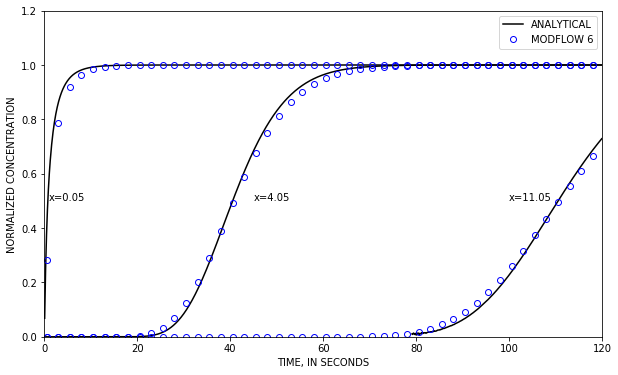

In [19]:
# these parameters are for figure 18 in the moc3d report

ws = 'temp/p01'
name = 'p01'

l = 12.
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 0.1
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = None
cidx = [(0, 0, 0), (0, 40, 0), (0, 110, 0)]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes, cidx=cidx)

times = np.arange(0, 120, .1)

alabel = ['ANALYTICAL', '', '']
mlabel = ['MODFLOW 6', '', '']
iskip = 5
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(0, l, nrow)
for i, x in enumerate([0.05, 4.05, 11.05]):
    a1 = analytical.Wexler1d().analytical(x, times, v, l, d)
    idx = a1 < 0
    a1[idx] = 0
    idx = a1 > 1
    a1[idx] = 0
    idx = times > 0
    if i == 2:
        idx = times > 79
    ax.plot(times[idx], a1[idx], color='k', label=alabel[i])
    ax.plot(cts[::iskip, 0], cts[::iskip, i+1], marker='o', ls='none',
             mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.2)
ax.set_xlim(0, 120)
ax.set_xlabel('TIME, IN SECONDS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(1, .5, 'x=0.05')
ax.text(45, .5, 'x=4.05')
ax.text(100, .5, 'x=11.05')
fname = '../Figures/p01a.pdf'
plt.savefig(fname)

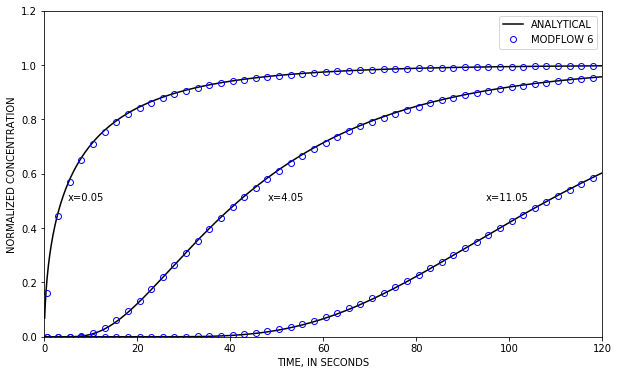

In [20]:
# these parameters are for figure 19 in the moc3d report

ws = 'temp/p01'
name = 'p01'

l = 12.
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 1.0
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = None
cidx = [(0, 0, 0), (0, 40, 0), (0, 110, 0)]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes, cidx=cidx)

times = np.arange(0, 120, .1)

alabel = ['ANALYTICAL', '', '']
mlabel = ['MODFLOW 6', '', '']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
iskip = 5
for i, x in enumerate([0.05, 4.05, 11.05]):
    a1 = analytical.Wexler1d().analytical(x, times, v, l, d)
    #idx = a1 < 0
    #a1[idx] = 0
    #idx = a1 > 1
    #a1[idx] = 0
    idx = times > 0
    #if i == 2:
    #    idx = times > 79
    ax.plot(times[idx], a1[idx], color='k', label=alabel[i])
    ax.plot(cts[::iskip, 0], cts[::iskip, i+1], marker='o', ls='none',
             mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.2)
ax.set_xlim(0, 120)
ax.set_xlabel('TIME, IN SECONDS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(5, .5, 'x=0.05')
ax.text(48, .5, 'x=4.05')
ax.text(95, .5, 'x=11.05')
fname = '../Figures/p01b.pdf'
plt.savefig(fname)

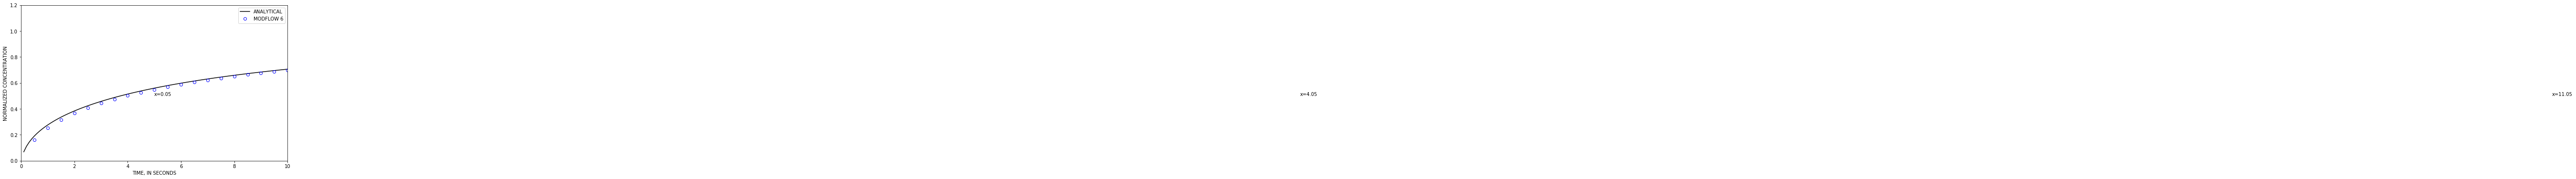

In [21]:
# Konikow figures 20 and 21
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
iskip = 1
for i, x in enumerate([0.05]):
    a1 = analytical.Wexler1d().analytical(x, times, v, l, d)
    #idx = a1 < 0
    #a1[idx] = 0
    #idx = a1 > 1
    #a1[idx] = 0
    idx = times > 0
    #if i == 2:
    #    idx = times > 79
    ax.plot(times[idx], a1[idx], color='k', label=alabel[i])
    ax.plot(cts[::iskip, 0], cts[::iskip, i+1], marker='o', ls='none',
             mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.2)
ax.set_xlim(0, 10)
ax.set_xlabel('TIME, IN SECONDS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(5, .5, 'x=0.05')
ax.text(48, .5, 'x=4.05')
ax.text(95, .5, 'x=11.05')
fname = '../Figures/p01c.pdf'
plt.savefig(fname)

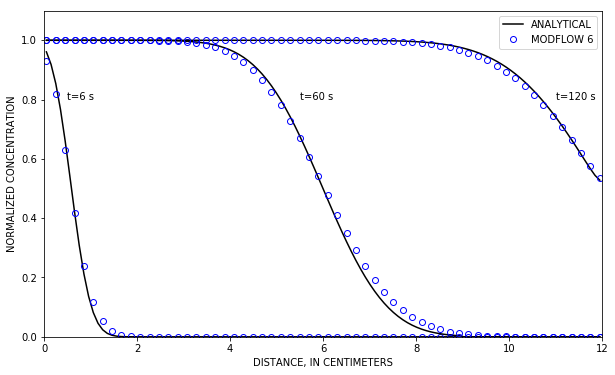

In [22]:
# Konikow figure 22
ws = 'temp/p01'
name = 'p01'

l = 12.0
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 0.1
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = [6., 60., 120.]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes)

alabel = ['ANALYTICAL', '', '', '']
mlabel = ['MODFLOW 6', '', '', '']
iskip = 2

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(.5 * delc, l - .5 * delc, nrow - 1)
for i, t in enumerate(ctimes):
    a1 = analytical.Wexler1d().analytical2(x, t, v, l, d, decay_rate)
    idx = x > l
    if i == 0:
        idx = x > 6
    if i == 1:
        idx = x > 9
    a1[idx] = 0.
    ax.plot(x, a1, color='k', label=alabel[i])
    ax.plot(x[::iskip], clist[i][0, ::iskip, 0], marker='o', ls='none',
            mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 12)
ax.text(.5, .8, 't=6 s')
ax.text(5.5, .8, 't=60 s')
ax.text(11, .8, 't=120 s')
ax.set_xlabel('DISTANCE, IN CENTIMETERS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
plt.legend()
fname = '../Figures/p01d.pdf'
plt.savefig(fname)

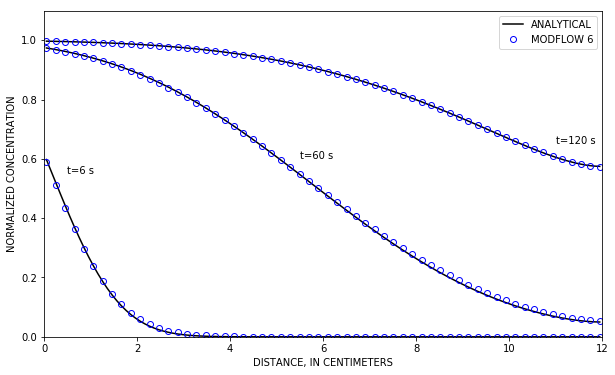

In [23]:
# Konikow does not have this figure
ws = 'temp/p01'
name = 'p01'

l = 12.0
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 1.0
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = [6., 60., 120.]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes)

alabel = ['ANALYTICAL', '', '', '']
mlabel = ['MODFLOW 6', '', '', '']
iskip = 2

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(.5 * delc, l - .5 * delc, nrow - 1)
for i, t in enumerate(ctimes):
    a1 = analytical.Wexler1d().analytical2(x, t, v, l, d, decay_rate)
    idx = x > l
    a1[idx] = 0.
    ax.plot(x, a1, color='k', label=alabel[i])
    ax.plot(x[::iskip], clist[i][0, ::iskip, 0], marker='o', ls='none',
            mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 12)
ax.text(.5, .55, 't=6 s')
ax.text(5.5, .6, 't=60 s')
ax.text(11, .65, 't=120 s')
ax.set_xlabel('DISTANCE, IN CENTIMETERS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
plt.legend()
fname = '../Figures/p01e.pdf'
plt.savefig(fname)

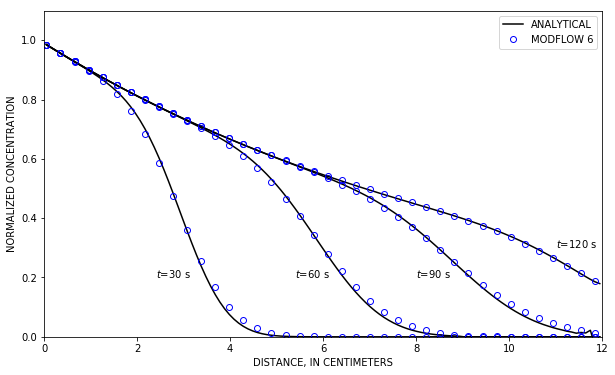

In [24]:
ws = 'temp/p01'
name = 'p01'

# these parameters are for figure 22 in the moc3d report
l = 12.0
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 0.1
alv = alh
d = alh * v
rtd = None
decay_rate = 0.01
ctimes = [30., 60., 90., 120.]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes)

alabel = ['ANALYTICAL', '', '', '']
mlabel = ['MODFLOW 6', '', '', '']
iskip = 3
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(.5 * delc, l - .5 * delc, nrow - 1)
for i, t in enumerate(ctimes):
    a1 = analytical.Wexler1d().analytical2(x, t, v, l, d, decay_rate)
    idx = x > l
    if i == 0:
        idx = x > 6
    if i == 1:
        idx = x > 9
    a1[idx] = 0.
    ax.plot(x, a1, color='k', label=alabel[i])
    ax.plot(x[::iskip], clist[i][0, ::iskip, 0], marker='o', ls='none',
            mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 12)
ax.text(2.4, .2, '$t$=30 s')
ax.text(5.4, .2, '$t$=60 s')
ax.text(8.0, .2, '$t$=90 s')
ax.text(11, .3, '$t$=120 s')
ax.set_xlabel('DISTANCE, IN CENTIMETERS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
plt.legend()
fname = '../Figures/p01f.pdf'
plt.savefig(fname)

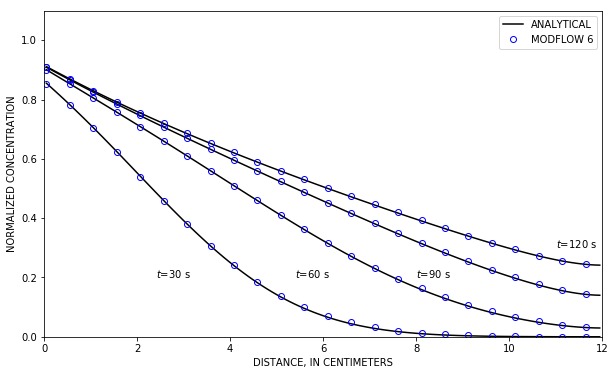

In [25]:
# Konikow does not have this figure
ws = 'temp/p01'
name = 'p01'

l = 12.0
v = .1
nrow = 120
delc = l / nrow
diffc = 0.
alh = 1.0
alv = alh
d = alh * v
rtd = None
decay_rate = 0.01
ctimes = [30., 60., 90., 120.]
sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate,
                             ctimes=ctimes)

alabel = ['ANALYTICAL', '', '', '']
mlabel = ['MODFLOW 6', '', '', '']
iskip = 5

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(.5 * delc, l - .5 * delc, nrow - 1)
for i, t in enumerate(ctimes):
    a1 = analytical.Wexler1d().analytical2(x, t, v, l, d, decay_rate)
    idx = x > l
    a1[idx] = 0.
    ax.plot(x, a1, color='k', label=alabel[i])
    ax.plot(x[::iskip], clist[i][0, ::iskip, 0], marker='o', ls='none',
            mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 12)
ax.text(2.4, .2, '$t$=30 s')
ax.text(5.4, .2, '$t$=60 s')
ax.text(8.0, .2, '$t$=90 s')
ax.text(11, .3, '$t$=120 s')
ax.set_xlabel('DISTANCE, IN CENTIMETERS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
plt.legend()
fname = '../Figures/p01g.pdf'
plt.savefig(fname)

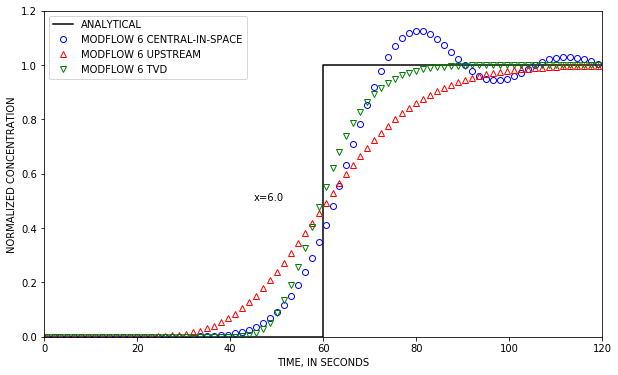

In [26]:
# these parameters are not in Konikow, but the point here is to
# show how the schemes work when there is no dispersion

ws = 'temp/p01'
name = 'p01'

l = 12.
v = .1
nrow = 31
delc = l / nrow
diffc = 0.
alh = 0.0
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = None
obs_row = int(nrow / 2)
cidx = [(0, obs_row, 0), ]

ctslist = []
for advscheme in ['central', 'upstream', 'tvd']:
    sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate, 
                                advscheme=advscheme,
                                ctimes=ctimes, cidx=cidx, verbosity_level=0)
    ctslist.append(cts)

alabel = ['ANALYTICAL', '', '']
mlabel = ['MODFLOW 6 CENTRAL-IN-SPACE', 
          'MODFLOW 6 UPSTREAM', 
          'MODFLOW 6 TVD']
mecs = ['blue', 'red', 'green']
markers = ['o', '^', 'v']
iskip = 3
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)

obs_distance = obs_row * delc + .5 * delc
t_arrival = obs_distance / v

ax.plot([0, t_arrival, t_arrival, 120.], [0, 0, 1, 1], color='k', label=alabel[0])
for i, cts in enumerate(ctslist):
    ax.plot(cts[::iskip, 0], cts[::iskip, 1], marker=markers[i], ls='none',
            mec=mecs[i], mfc='none', label=mlabel[i])


ax.set_ylim(0, 1.2)
ax.set_xlim(0, 120)
ax.set_xlabel('TIME, IN SECONDS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(45, .5, 'x={}'.format(obs_distance))
fname = '../Figures/p01h.pdf'
plt.savefig(fname)

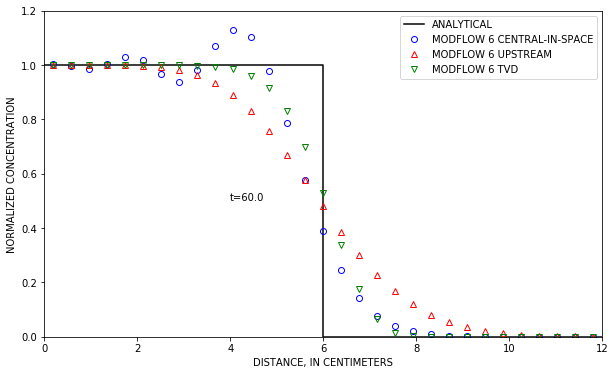

In [27]:
# these parameters are not in Konikow, but the point here is to
# show how the schemes work when there is no dispersion

ws = 'temp/p01'
name = 'p01'

l = 12.
v = .1
nrow = 31
delc = l / nrow
diffc = 0.
alh = 0.0
alv = alh
d = alh * v
rtd = None
decay_rate = 0.
ctimes = [60.]
obs_row = int(nrow / 2)
cidx = [(0, obs_row, 0), ]

ctslist = []
cgridlist = []
for advscheme in ['central', 'upstream', 'tvd']:
    sim, clist, cts = get_model(ws, name, nrow, delc, diffc, alh, alv, rtd, decay_rate, 
                                advscheme=advscheme, 
                                ctimes=ctimes, cidx=cidx, verbosity_level=0)
    ctslist.append(cts)
    cgridlist.append(clist)

alabel = ['ANALYTICAL', '', '']
mlabel = ['MODFLOW 6 CENTRAL-IN-SPACE', 
          'MODFLOW 6 UPSTREAM', 
          'MODFLOW 6 TVD']
mecs = ['blue', 'red', 'green']
markers = ['o', '^', 'v']
iskip = 1

obs_distance = obs_row * delc + .5 * delc
d_arrival = v * t_arrival
x = np.linspace(delc/2, nrow * delc - delc/2, nrow)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot([0, d_arrival, d_arrival, 120.], [1, 1, 0, 0], color='k', label=alabel[0])
for i, clist in enumerate(cgridlist):
    cgrid = clist[0].flatten()
    plt.plot(x[::iskip], cgrid[::iskip], marker=markers[i], ls='none',
            mec=mecs[i], mfc='none', label=mlabel[i])


ax.set_ylim(0, 1.2)
ax.set_xlim(0, l)
ax.set_xlabel('DISTANCE, IN CENTIMETERS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(4, .5, 't={}'.format(t_arrival))
fname = '../Figures/p01i.pdf'
plt.savefig(fname)